## 1. Cleanup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geojson
import numpy as np
import rasterio
import contextily
from sklearn.neighbors import BallTree
from shapely.geometry import LineString
from shapely.geometry import Point, MultiPoint

In [2]:
df = pd.read_csv('DataSample.csv')
df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730
...,...,...,...,...,...,...,...
22020,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560
22021,5614888,2017-06-21 08:23:01.793,CA,AB,Calgary,51.02093,-114.10621
22022,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220
22023,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22025 entries, 0 to 22024
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   _ID        22025 non-null  int64  
 1    TimeSt    22025 non-null  object 
 2   Country    22025 non-null  object 
 3   Province   22025 non-null  object 
 4   City       22025 non-null  object 
 5   Latitude   22025 non-null  float64
 6   Longitude  22025 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.2+ MB


In [4]:
df.describe()

,_ID,Latitude,Longitude
count,2.202500e+04,22025.000000,22025.000000
mean,5.067292e+06,47.983484,-94.967281
std,3.175577e+05,4.165093,19.092001
min,4.516516e+06,6.927420,-136.539570
25%,4.792159e+06,43.747600,-113.814000
50%,5.067906e+06,47.798700,-83.018000
75%,5.342586e+06,51.128560,-79.399100
max,5.615006e+06,62.827300,125.702200


In [5]:
# Cleaning up the sample dataset (data/DataSample.csv) by filtering out those questionable/duplicates request records.
df_clean = df.sort_values(' TimeSt').drop_duplicates(['Country', 'Province', 'City', 'Latitude', 'Longitude'], keep=False)
df_clean

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
169,4524947,2017-06-21 00:00:06.163,CA,ON,Kitchener,43.43060,-80.48770
17265,5380915,2017-06-21 00:01:02.690,CA,AB,Calgary,51.15880,-113.96360
401,4536827,2017-06-21 00:01:06.527,CA,ON,Oshawa,43.90635,-78.87251
17404,5387037,2017-06-21 00:01:39.167,CA,QC,Chibougamau,49.91680,-74.36590
...,...,...,...,...,...,...,...
16198,5326962,2017-06-21 22:56:43.763,CA,ON,Etobicoke,43.63931,-79.56384
16319,5332865,2017-06-21 22:57:20.567,CA,BC,Vanderhoof,54.01646,-124.00783
16564,5345047,2017-06-21 22:58:31.267,CA,AB,Edmonton,53.54415,-113.53385
16671,5350538,2017-06-21 22:59:01.293,CA,ON,Oakville,43.45400,-79.69200


In [6]:
df2 = pd.read_csv('POIList.csv');
df2.columns = df2.columns.to_series().apply(lambda x: x.strip())  # Removes any KeyError for column index
df2

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


## 2. Label

In [7]:
# Assign each request (from data/DataSample.csv) to the closest (i.e., minimum distance) POI (from data/POIList.csv)

# Step 1i: Combining Latitude and longitude for both df_clean to create point coordinates/geometry

df_clean['geometry'] = df_clean[['Latitude', 'Longitude']].values.tolist()
df_clean.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,geometry
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,"[43.49347, -80.49123]"
169,4524947,2017-06-21 00:00:06.163,CA,ON,Kitchener,43.43060,-80.48770,"[43.4306, -80.4877]"
17265,5380915,2017-06-21 00:01:02.690,CA,AB,Calgary,51.15880,-113.96360,"[51.1588, -113.9636]"
401,4536827,2017-06-21 00:01:06.527,CA,ON,Oshawa,43.90635,-78.87251,"[43.90635, -78.87251]"
17404,5387037,2017-06-21 00:01:39.167,CA,QC,Chibougamau,49.91680,-74.36590,"[49.9168, -74.3659]"


In [8]:
# Step 1ii: Change the coordinates/geometry to a geoPlot

df_clean['geometry'] = df_clean['geometry'].apply(Point)
df_clean.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,geometry
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POINT (43.49347 -80.49123)
169,4524947,2017-06-21 00:00:06.163,CA,ON,Kitchener,43.43060,-80.48770,POINT (43.4306 -80.4877)
17265,5380915,2017-06-21 00:01:02.690,CA,AB,Calgary,51.15880,-113.96360,POINT (51.1588 -113.9636)
401,4536827,2017-06-21 00:01:06.527,CA,ON,Oshawa,43.90635,-78.87251,POINT (43.90635 -78.87251000000001)
17404,5387037,2017-06-21 00:01:39.167,CA,QC,Chibougamau,49.91680,-74.36590,POINT (49.9168 -74.3659)


In [9]:
# Step 1iii: Combining Latitude and longitude for both df2 to create point coordinates/geometry

df2['geometry'] = df2[['Latitude', 'Longitude']].values.tolist()
df2.head()

,POIID,Latitude,Longitude,geometry
0,POI1,53.546167,-113.485734,"[53.546167, -113.485734]"
1,POI2,53.546167,-113.485734,"[53.546167, -113.485734]"
2,POI3,45.521629,-73.566024,"[45.521629, -73.566024]"
3,POI4,45.224830,-63.232729,"[45.22483, -63.232729]"


In [10]:
# Step 1iv: Change the coordinates/geometry to a geoPlot

df2['geometry'] = df2['geometry'].apply(Point)
df2.head()

,POIID,Latitude,Longitude,geometry
0,POI1,53.546167,-113.485734,POINT (53.546167 -113.485734)
1,POI2,53.546167,-113.485734,POINT (53.546167 -113.485734)
2,POI3,45.521629,-73.566024,POINT (45.521629 -73.566024)
3,POI4,45.224830,-63.232729,POINT (45.22483 -63.232729)


In [11]:
# Step 2i: Checking the type of the df_clean dataframe and column coordinates/geometry of df_clean data
type(df_clean)

pandas.core.frame.DataFrame

In [12]:
type(df_clean['geometry'])

pandas.core.series.Series

In [13]:
# After converting the data into geospatial data, we will check the type of df_clean dataframe and column coordinates/geometry data again...
gpd1 = gpd.GeoDataFrame(df_clean, geometry='geometry')
gpd1.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,geometry
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POINT (43.493 -80.491)
169,4524947,2017-06-21 00:00:06.163,CA,ON,Kitchener,43.43060,-80.48770,POINT (43.431 -80.488)
17265,5380915,2017-06-21 00:01:02.690,CA,AB,Calgary,51.15880,-113.96360,POINT (51.159 -113.964)
401,4536827,2017-06-21 00:01:06.527,CA,ON,Oshawa,43.90635,-78.87251,POINT (43.906 -78.873)
17404,5387037,2017-06-21 00:01:39.167,CA,QC,Chibougamau,49.91680,-74.36590,POINT (49.917 -74.366)


In [14]:
type(gpd1)

geopandas.geodataframe.GeoDataFrame

In [15]:
type(gpd1['geometry'])

geopandas.geoseries.GeoSeries

In [16]:
# Step 2ii: Checking the type of the df2 dataframe and column coordinates/geometry of df2 data
type(df2)

pandas.core.frame.DataFrame

In [17]:
type(df2['geometry'])

pandas.core.series.Series

In [18]:
# After converting the data into geospatial data, we will check the type of df2 dataframe and column coordinates/geometry data again...
gpd2 = gpd.GeoDataFrame(df2, geometry='geometry')
gpd2.head()

,POIID,Latitude,Longitude,geometry
0,POI1,53.546167,-113.485734,POINT (53.546 -113.486)
1,POI2,53.546167,-113.485734,POINT (53.546 -113.486)
2,POI3,45.521629,-73.566024,POINT (45.522 -73.566)
3,POI4,45.224830,-63.232729,POINT (45.225 -63.233)


In [19]:
type(gpd2)

geopandas.geodataframe.GeoDataFrame

In [20]:
type(gpd2['geometry'])

geopandas.geoseries.GeoSeries

In [21]:
print(gpd2.head(), '\n--------')
print(gpd1.head())

  POIID   Latitude   Longitude                 geometry
0  POI1  53.546167 -113.485734  POINT (53.546 -113.486)
1  POI2  53.546167 -113.485734  POINT (53.546 -113.486)
2  POI3  45.521629  -73.566024   POINT (45.522 -73.566)
3  POI4  45.224830  -63.232729   POINT (45.225 -63.233) 
--------
           _ID                   TimeSt Country Province         City  \
0      4516516  2017-06-21 00:00:00.143      CA       ON     Waterloo   
169    4524947  2017-06-21 00:00:06.163      CA       ON    Kitchener   
17265  5380915  2017-06-21 00:01:02.690      CA       AB      Calgary   
401    4536827  2017-06-21 00:01:06.527      CA       ON       Oshawa   
17404  5387037  2017-06-21 00:01:39.167      CA       QC  Chibougamau   

       Latitude  Longitude                 geometry  
0      43.49347  -80.49123   POINT (43.493 -80.491)  
169    43.43060  -80.48770   POINT (43.431 -80.488)  
17265  51.15880 -113.96360  POINT (51.159 -113.964)  
401    43.90635  -78.87251   POINT (43.906 -78.873)  
1

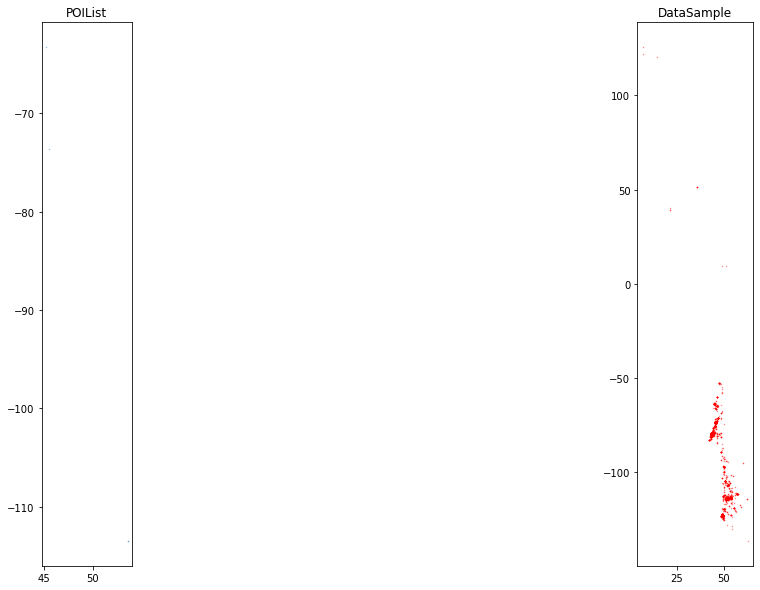

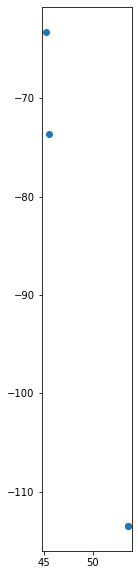

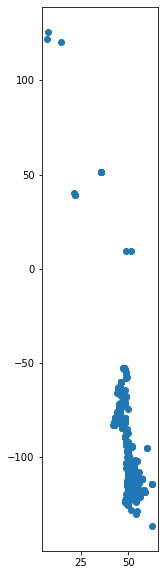

In [22]:
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot POIList
gpd2.plot(ax=axes[0],markersize=0.2, alpha=0.5)
gpd2.plot(figsize=(20,10));
axes[0].set_title('POIList')

# Plot DataSample
gpd1.plot(ax=axes[1], markersize=0.2, alpha=0.5, color='red')
gpd1.plot(figsize=(20,10))
axes[1].set_title('DataSample');

In [23]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

In [24]:
# Find closest stop for each Point of Interest and get also the distance based on haversine distance
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
# but useful as we get the distance between points in meters
closest_stops = nearest_neighbor(gpd2, gpd1, return_dist=True)

# And the result looks like ..
closest_stops

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,geometry,distance
0,5039366,2017-06-21 04:36:43.390,CA,AB,Edmonton,53.54636,-113.48047,POINT (53.546 -113.480),348.449138
1,5039366,2017-06-21 04:36:43.390,CA,AB,Edmonton,53.54636,-113.48047,POINT (53.546 -113.480),348.449138
2,5332594,2017-06-21 06:57:15.550,CA,QC,Montréal,45.51515,-73.56129,POINT (45.515 -73.561),809.359040
3,4890606,2017-06-21 07:26:39.330,CA,NS,Truro,45.36940,-63.27970,POINT (45.369 -63.280),16489.941143


In [25]:
# Now we should have exactly the same number of closest_stops as we have Point of Interest
print(len(closest_stops), '==', len(gpd2))

4 == 4


In [26]:
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_stops = closest_stops.rename(columns={'geometry': 'closest_stop_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function). Note that without passing the how, lsuffix and rsuffix arguments, you'll likely get a "ValueError: columns overlap"
gpd2 = gpd2.join(closest_stops, how = 'left', lsuffix = '_left', rsuffix = '_right')

# Let's see what we have
gpd2.head()

,POIID,Latitude_left,Longitude_left,geometry,_ID,TimeSt,Country,Province,City,Latitude_right,Longitude_right,closest_stop_geom,distance
0,POI1,53.546167,-113.485734,POINT (53.546 -113.486),5039366,2017-06-21 04:36:43.390,CA,AB,Edmonton,53.54636,-113.48047,POINT (53.546 -113.480),348.449138
1,POI2,53.546167,-113.485734,POINT (53.546 -113.486),5039366,2017-06-21 04:36:43.390,CA,AB,Edmonton,53.54636,-113.48047,POINT (53.546 -113.480),348.449138
2,POI3,45.521629,-73.566024,POINT (45.522 -73.566),5332594,2017-06-21 06:57:15.550,CA,QC,Montréal,45.51515,-73.56129,POINT (45.515 -73.561),809.359040
3,POI4,45.224830,-63.232729,POINT (45.225 -63.233),4890606,2017-06-21 07:26:39.330,CA,NS,Truro,45.36940,-63.27970,POINT (45.369 -63.280),16489.941143


## 3. Analysis

In [27]:
# 1. For each POI, we'll calculate the average and standard deviation of the distance between the POI to each of its assigned requests.

gpd2['distance'].describe()

count        4.000000
mean      4499.049615
std       7996.879909
min        348.449138
25%        348.449138
50%        578.904089
75%       4729.504566
max      16489.941143
Name: distance, dtype: float64

<AxesSubplot:>

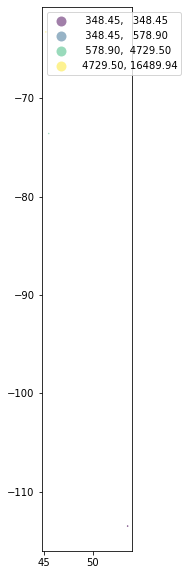

In [28]:
gpd2.plot(column='distance', markersize=0.2, alpha=0.5, figsize=(20,10), scheme='quantiles', k=4,legend=True)

In [29]:
# from shapely.geometry import LineString

# Create a link (LineString) between Point of Interest and DataSample points
gpd2['link'] = gpd2.apply(lambda row: LineString([row['geometry'], row['closest_stop_geom']]), axis=1)

# Set link as the active geometry
gpd2_links = gpd2.copy()
gpd2_links = gpd2_links.set_geometry('link')

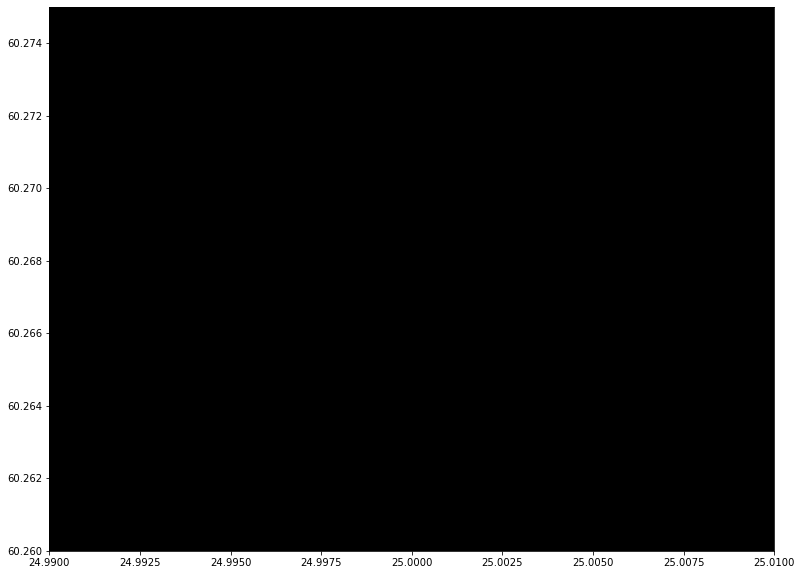

In [30]:
# Plot the connecting links between Point of Interest and DataSample and color them based on distance
ax = gpd2_links.plot(column='distance', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.7, figsize=(13, 10))
ax = gpd2.plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
ax = gpd1.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Zoom closer
ax.set_xlim([24.99, 25.01])
ax.set_ylim([60.26, 60.275])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')

## 4. Data Science/Engineering Tracks

In [31]:
from osgeo import gdal
'''
df2.to_csv("dfn.xyz", index=False, header=None, sep=" ")
demn = gdal.Translate("demn.tiff", "dfn.xyz", outputSRS = "EPSG:32719")
demn = None
'''

'\ndf2.to_csv("dfn.xyz", index=False, header=None, sep=" ")\ndemn = gdal.Translate("demn.tiff", "dfn.xyz", outputSRS = "EPSG:32719")\ndemn = None\n'

## 4a. Model

C:\ProgramData\Anaconda3\envs\gis\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


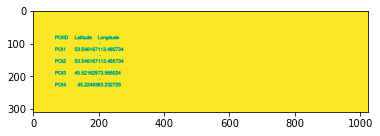

<AxesSubplot:>

In [32]:
# Visualizing the popularity of each POI, by mapping them to a scale that ranges from -10 to 10. With an aim to be more sensitive around the average and give as much visual differentiability as possible.

import rasterio
from rasterio.plot import show
import numpy as np
import os
%matplotlib inline


# Data dir
data_dir = r"C:\Users\Nonso Onyia\Desktop\eqworks_ challenge"

# Filepath
fp = os.path.join(data_dir, "POIList.tiff")

# Open the file:
raster = rasterio.open(fp)
'''
def export_window(fp, path):
    number_of_bands, height, width = fp.shape

    profile = {
        "driver": "JPEG",
        "count": number_of_bands,
        "height": height,
        "width": width,
        'dtype': 'uint8',
        'transform': rasterio.Affine(1),
    }
    with rasterio.open(path, 'fp', **profile) as dst:
        dst.write(fp)
'''

# Plot band 1
show((raster, 1))

Text(0.5, 1.0, 'Blue')

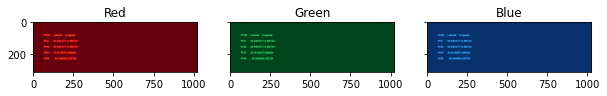

In [33]:
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((raster, 1), cmap='Reds', ax=ax1)
show((raster, 1), cmap='Greens', ax=ax2)
show((raster, 1), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

In [34]:
# Read the grid values into numpy arrays
red = raster.read(1)
green = raster.read(1)
blue = raster.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale -10 - 10"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.9907075738676151
0.0 - 1.0 mean: 0.9907075738676151
0.0 - 1.0 mean: 0.9907075738676151


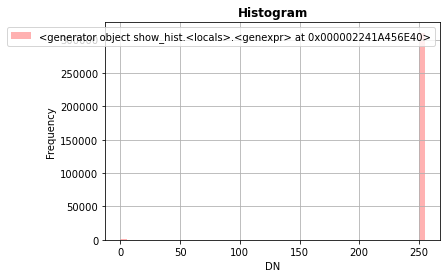

In [35]:
from rasterio.plot import show_hist

show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

## 4b. Pipeline Dependency - DAG

In [36]:
# Step 1: Import modules

from airflow.models import DAG
from airflow.models import BaseOperator
from airflow.operators.subdag import SubDagOperator
from airflow.operators.bash import BashOperator
from airflow.operators.dummy import DummyOperator  
#from airflow.operators.python import PythonOperator
from datetime import datetime, timedelta

In [37]:
# Step 2: Define default arguments

default_args = {
    "owner": "airflow",
    "depends_on_past": True,
    "start_date": datetime(2021, 6, 7),
    "retries": 1,
    "retry_delay": timedelta(minutes=3)  # If a task fails, retry it once, at least every 3 minutes
}

In [38]:
# Step 3: Create DAG Object/Instantiate the DAG

dag = DAG(dag_id="DAG-1", default_args=default_args, description= "EQ_Works_DAG", catchup=False, schedule_interval="@daily")

In [39]:
# Step 4: Define task
# Starting_task to t18 are examples of tasks created by instantiating operators

starting_task = BashOperator(
    task_id= "73",
    bash_command="date",
    dag=dag
)

t2 = BashOperator(
    task_id= "97",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t3 = BashOperator(
    task_id= "75",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t4 = BashOperator(
    task_id= "100",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t5 = BashOperator(
    task_id= "102",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t6 = BashOperator(
    task_id= "16",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t7 = BashOperator(
    task_id= "39",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t8 = BashOperator(
    task_id= "41",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t9 = BashOperator(
    task_id= "62",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t10 = BashOperator(
    task_id= "112",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t11 = BashOperator(
    task_id= "20",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t12 = BashOperator(
    task_id= "21",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t13 = BashOperator(
    task_id= "56",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t14 = BashOperator(
    task_id= "55",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t15 = BashOperator(
    task_id= "36",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t16 = BashOperator(
    task_id= "37",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

t17 = BashOperator(
    task_id= "94",
    depends_on_past=True,
    bash_command="sleep 10",
    dag=dag
)

templated_command = """
{% for i in range(5) %}
    echo "{{ ds }}"
    echo "{{ macros.ds_add(ds, 7)}}"
    echo "{{ params.my_param }}"
{% endfor %}
"""

t18 = BashOperator(
    task_id= "31",
    depends_on_past=True,
    bash_command=templated_command,
    params={"my_param": "Parameter I passed in"},
    dag=dag
)

In [40]:
# Step 5: Define dependencies

# Using the bit shift operator to chain operations. Also note that a List of tasks can also be set as dependencies
t2 >> t5
t18 >> [t18, t16]
t11 >> t4
t5 >> [t15, t16, t18]
t6 >> t16
t7 >> [starting_task, t4]
t8 >> [starting_task, t10]
t9 >> t14
t10 >> t2 
t11 >> [t17, t2]
t12 >> t11
starting_task >> t11
t13 >> [t5, t3, t14]
t14 >> [t18, t16]
t17 >> [t13, t5]
[t13, t5] >> t15

<Task(BashOperator): 36>